In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, spearmanr

In [2]:
df = pd.read_csv('dataset_SCL.csv',parse_dates=['Fecha-I','Fecha-O'])
df.head()

/Users/juanito/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [3]:
df.columns = df.columns.str.strip()
df.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES'],
      dtype='object')

In [4]:
print('---------------------------\nInformación general:\n---------------------------')
df.info()
print('\n---------------------------\nValores únicos por columna:\n---------------------------\n',df.nunique())


---------------------------
Información general:
---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  object        
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68205 non-null  object        
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int64         
 11  MES        68206 non-null  int64         
 12  AÑO        68206 non-null  int64         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA     

In [5]:
print('---------------------------\nInformación np.nan:\n---------------------------\n',df.isna().sum())

print('---------------------------\nInformación duplicada:\n---------------------------\n',np.where(df.duplicated()==True)[0])

---------------------------
Información np.nan:
---------------------------
 Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64
---------------------------
Información duplicada:
---------------------------
 []


In [6]:
print(df.loc[[]])


Empty DataFrame
Columns: [Fecha-I, Vlo-I, Ori-I, Des-I, Emp-I, Fecha-O, Vlo-O, Ori-O, Des-O, Emp-O, DIA, MES, AÑO, DIANOM, TIPOVUELO, OPERA, SIGLAORI, SIGLADES]
Index: []


In [7]:
#df = df[df['Vlo-O'].notna()]
#df = df.dropna()
df['Vlo-O'][np.where(df['Vlo-O'].isna())[0]] = df['Vlo-I'][np.where(df['Vlo-O'].isna())[0]]
df["Vlo-O"] = df["Vlo-O"].astype(str)
df["Vlo-I"] = df["Vlo-I"].astype(str)

/Users/juanito/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


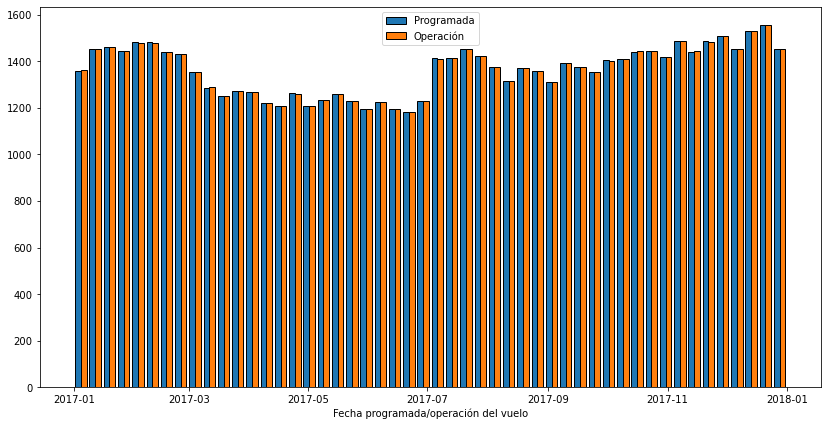

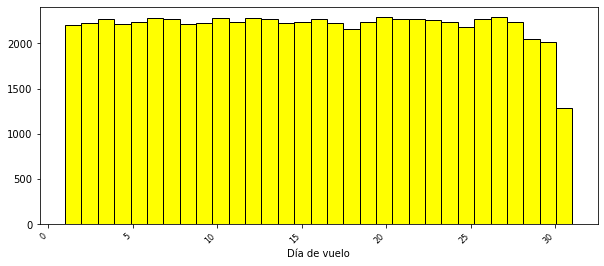

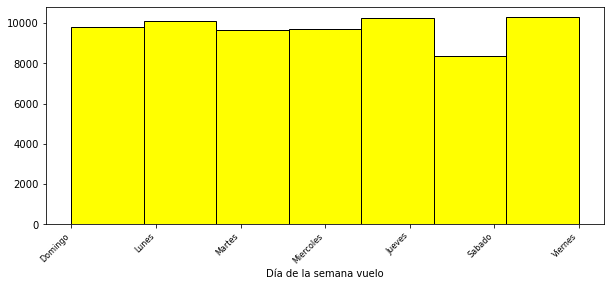

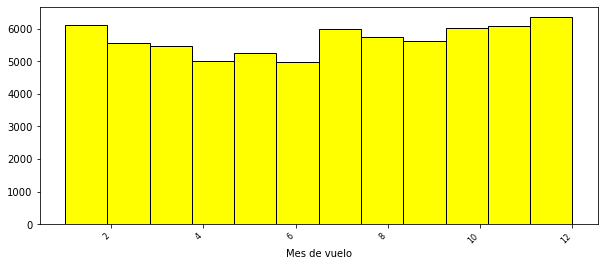

In [8]:
plt.figure(1,figsize=(14,7))
plt.hist([df['Fecha-I'],df['Fecha-O']],50,edgecolor='black')#,color='yellow')
plt.xlabel('Fecha programada/operación del vuelo')
plt.legend(['Programada','Operación'])
plt.show()

plt.figure(2,figsize=(10,4))
plt.hist(df['DIA'],31,edgecolor='black',color='yellow')
plt.xlabel('Día de vuelo')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()

plt.figure(3,figsize=(10,4))
plt.hist(df['DIANOM'],7,edgecolor='black',color='yellow')
plt.xlabel('Día de la semana vuelo')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()

plt.figure(4,figsize=(10,4))
plt.hist(df['MES'],12,edgecolor='black',color='yellow')
plt.xlabel('Mes de vuelo')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()


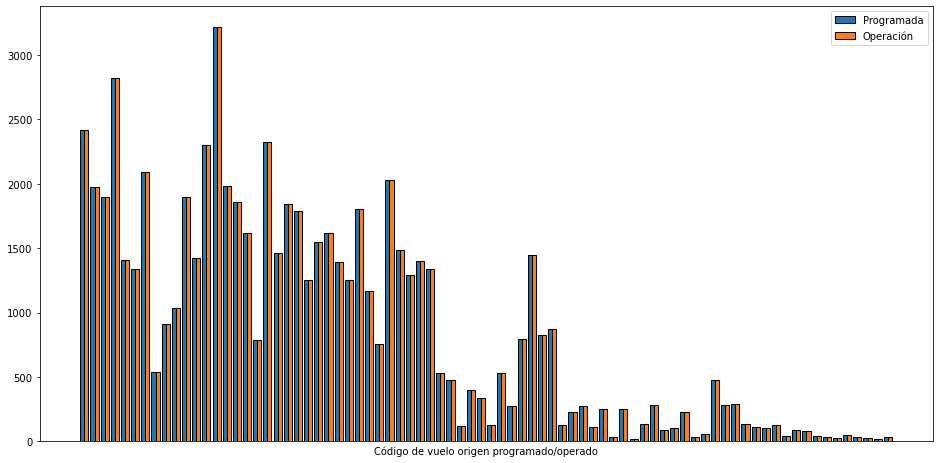

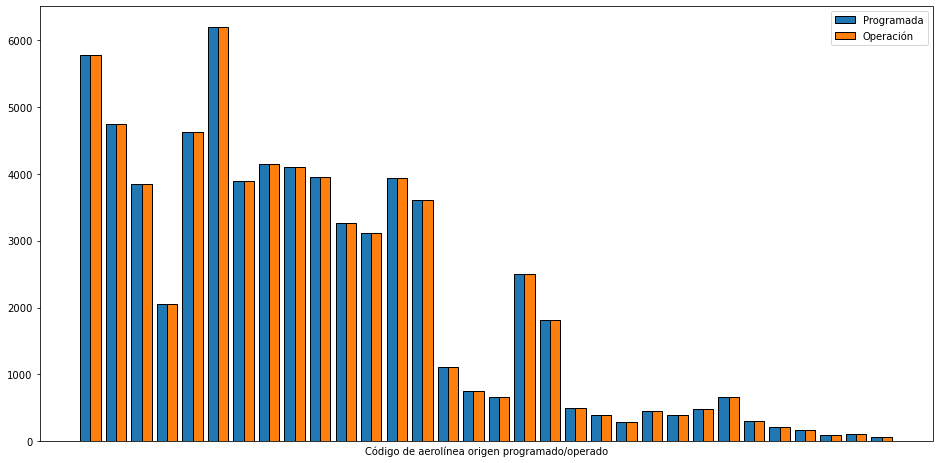

In [9]:
plt.figure(1,figsize=(16,8))
plt.hist([df['Vlo-I'],df['Vlo-I']],80,edgecolor='black')
plt.xlabel('Código de vuelo origen programado/operado')
plt.legend(['Programada','Operación'])
plt.xticks([])
plt.show()

plt.figure(1,figsize=(16,8))
plt.hist([df['Vlo-I'],df['Vlo-I']],32,edgecolor='black')
plt.xlabel('Código de aerolínea origen programado/operado')
plt.legend(['Programada','Operación'])
plt.xticks([])
plt.show()

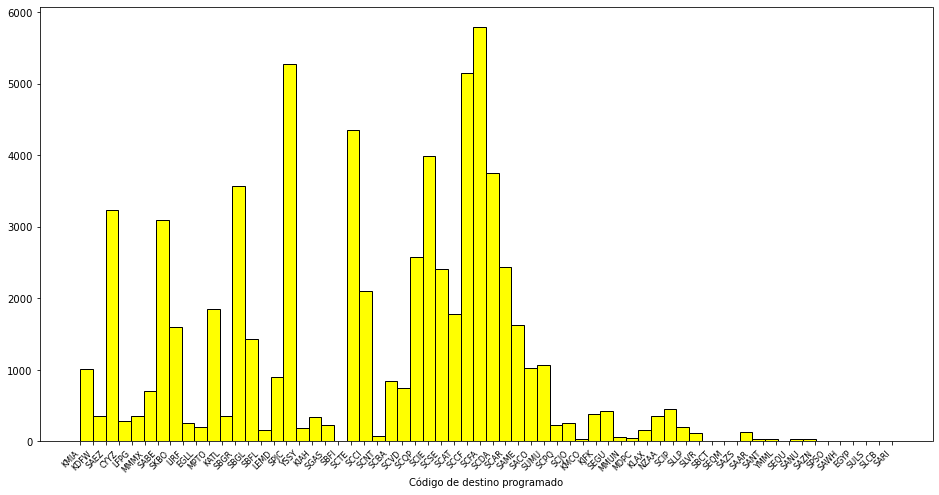

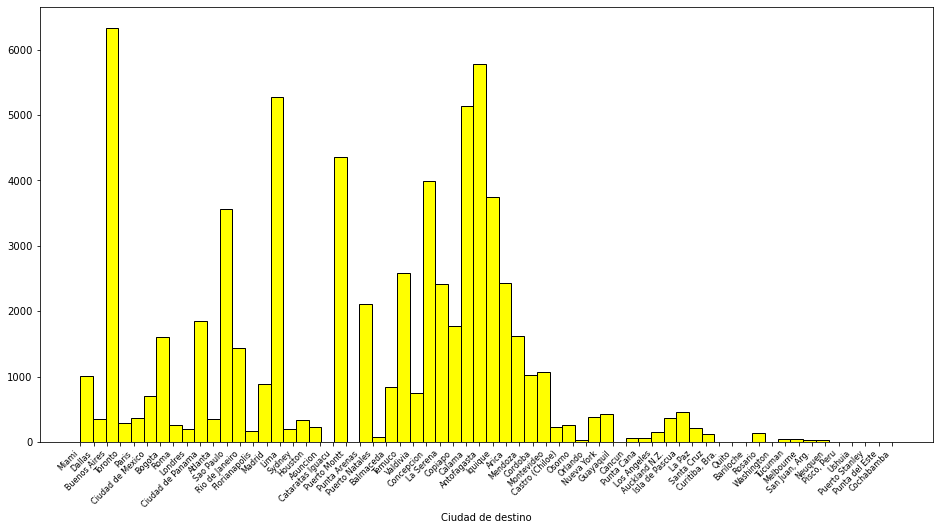

In [10]:
plt.figure(1,figsize=(16,8))
plt.hist(df['Des-I'],64,edgecolor='black',color='yellow')
plt.xlabel('Código de destino programado')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()

plt.figure(2,figsize=(16,8))
plt.hist(df['SIGLADES'],64,edgecolor='black',color='yellow')
plt.xlabel('Ciudad de destino')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()


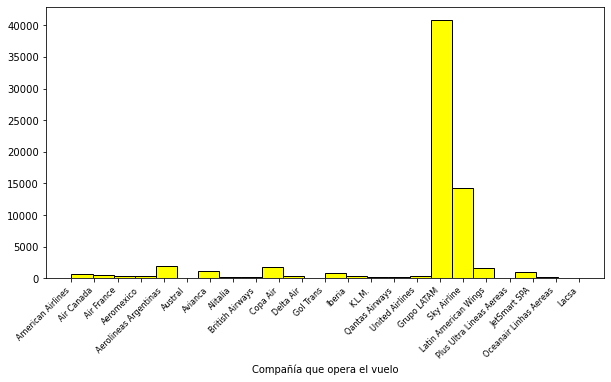

In [11]:
plt.figure(1,figsize=(10,5))
plt.hist(df['OPERA'],24,edgecolor='black',color='yellow')
plt.xlabel('Compañía que opera el vuelo')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()

[]

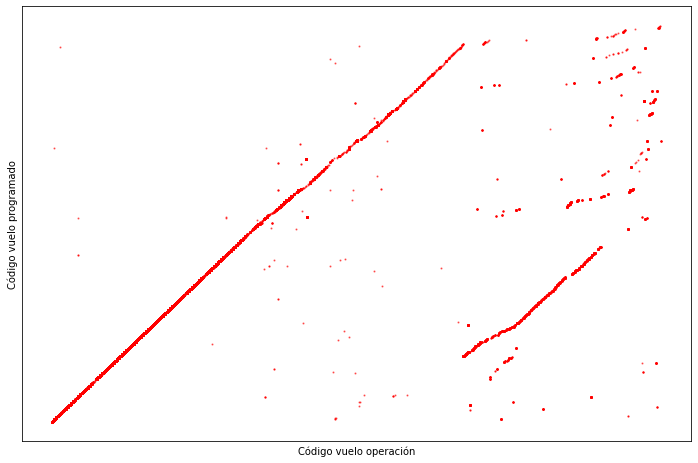

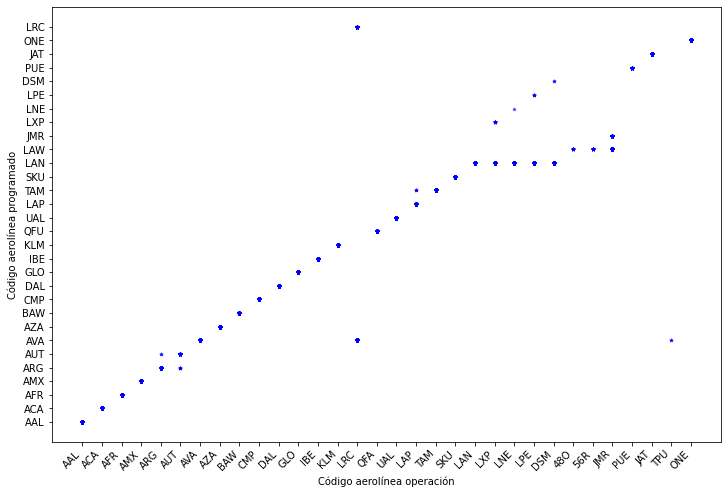

In [12]:
plt.figure(1,figsize=(12,8))
plt.xlabel(r'Código vuelo operación')
plt.ylabel(r'Código vuelo programado')
plt.scatter(df["Vlo-O"],df['Vlo-I'],marker='.',alpha=0.5,s=5,c='red')
plt.xticks([])
plt.yticks([])
plt.plot()

plt.figure(2,figsize=(12,8))
plt.xlabel(r'Código aerolínea operación')
plt.ylabel(r'Código aerolínea programado')
#plt.scatter(df[,df['Vlo-I'].astype(str),marker='.',alpha=0.5,c='red')
plt.scatter(df["Emp-O"],df['Emp-I'],marker='*',alpha=0.5,s=10,c='blue')
plt.xticks(rotation=45, ha="right")#,fontsize=8)
#plt.yticks([])
plt.plot()

In [13]:
dif_min = (df['Fecha-O']-df['Fecha-I']).dt.total_seconds()/60

In [14]:
col = df['Fecha-O']
print(min(col),max(col))

dif_min = (df['Fecha-O']-df['Fecha-I']).dt.total_seconds()/60
dif_min = np.round(dif_min,3)

I1 = np.where((col > '2017-12-15'))[0]
I2 = np.where((col > '2017-9-11') & (col < '2017-9-30'))[0]
I3 = np.where((col > '2017-7-15') & (col < '2017-7-31'))[0]
I4 = np.where((col > '2017-1-1') & (col < '2017-3-3'))[0]
temporada_alta = np.zeros(np.shape(col))
temporada_alta[I1] = 1
temporada_alta[I2] = 1
temporada_alta[I3] = 1
temporada_alta[I4] = 1

atraso_15 = np.zeros(np.shape(col))
atraso_15[dif_min>15] = 1

periodo_dia = np.zeros(np.shape(col),dtype=object)
I1 = np.where((col.dt.hour >= 5) & (col.dt.hour < 12))[0]
I2 = np.where((col.dt.hour >= 12) & (col.dt.hour < 19))[0]
I3 = np.where((col.dt.hour >= 19) | (col.dt.hour < 5))[0]
periodo_dia[I1] = 'mañana'
periodo_dia[I2] = 'tarde'
periodo_dia[I3] = 'noche'

2017-01-01 00:04:00 2018-01-01 00:12:00


In [15]:
synth = pd.DataFrame({'dif_min' : dif_min, 'atraso_15' : atraso_15, 'temporada_alta' : temporada_alta,
                      'periodo_dia':periodo_dia})
synth.to_csv(r'synthetic_features.csv',index=False)

In [16]:
df_synth = pd.read_csv('synthetic_features.csv')
df2 = pd.concat([df,df_synth],axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Fecha-I         68206 non-null  datetime64[ns]
 1   Vlo-I           68206 non-null  object        
 2   Ori-I           68206 non-null  object        
 3   Des-I           68206 non-null  object        
 4   Emp-I           68206 non-null  object        
 5   Fecha-O         68206 non-null  datetime64[ns]
 6   Vlo-O           68206 non-null  object        
 7   Ori-O           68206 non-null  object        
 8   Des-O           68206 non-null  object        
 9   Emp-O           68206 non-null  object        
 10  DIA             68206 non-null  int64         
 11  MES             68206 non-null  int64         
 12  AÑO             68206 non-null  int64         
 13  DIANOM          68206 non-null  object        
 14  TIPOVUELO       68206 non-null  object        
 15  OP

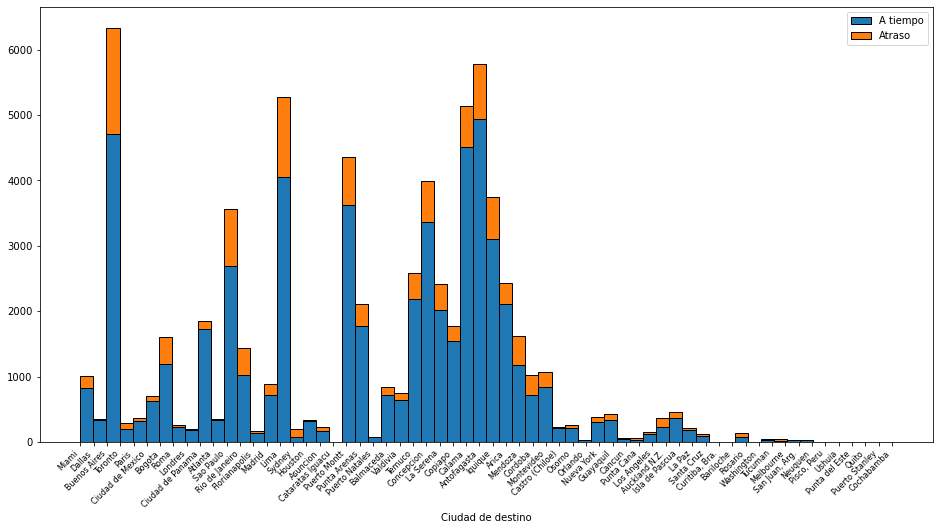

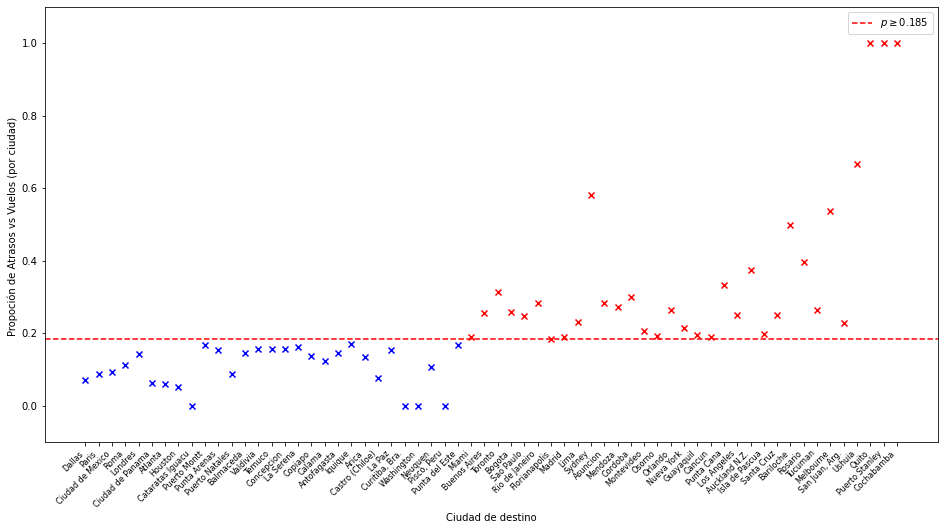

In [17]:
plt.figure(1,figsize=(16,8))
(n, bins, p) = plt.hist([df2['SIGLADES'][df2['atraso_15']==0],df2['SIGLADES'][df2['atraso_15']==1]],
                        62,edgecolor='black',stacked=True)
plt.xlabel('Ciudad de destino')
num, X = plt.xticks(rotation=45, ha="right",fontsize=8)
plt.legend(['A tiempo','Atraso'])
plt.show()

x = []
for s in X:
    x.append(s.get_text())
x = np.array(x)
prop = (n[1]-n[0])/n[1]

av_at = np.size(np.where(df2['atraso_15']>0)[0])/np.size(df2['atraso_15'])

plt.figure(2,figsize=(16,8))
plt.scatter(x[prop<=av_at],prop[prop<=av_at],marker='x',color='blue')
plt.scatter(x[prop>av_at],prop[prop>av_at],marker='x',color='red')
plt.axhline(y = av_at, color='red', linestyle='--',label=f'$p\geq {np.round(av_at,3)}$')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.ylim((0-0.1,1+0.1))
plt.xlabel('Ciudad de destino')
plt.ylabel('Propoción de Atrasos vs Vuelos (por ciudad) ')
plt.legend()
plt.show()

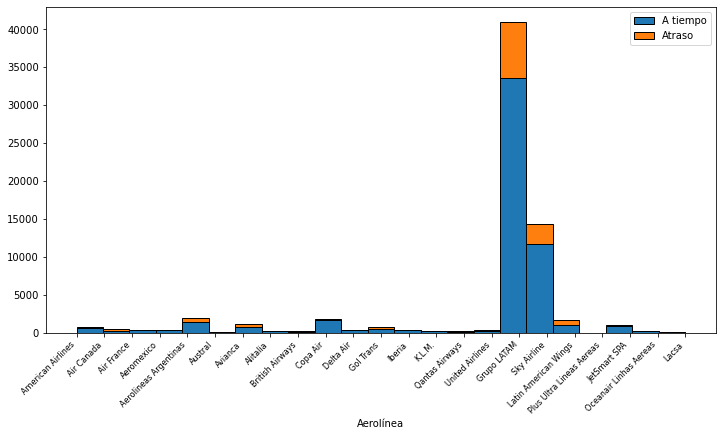

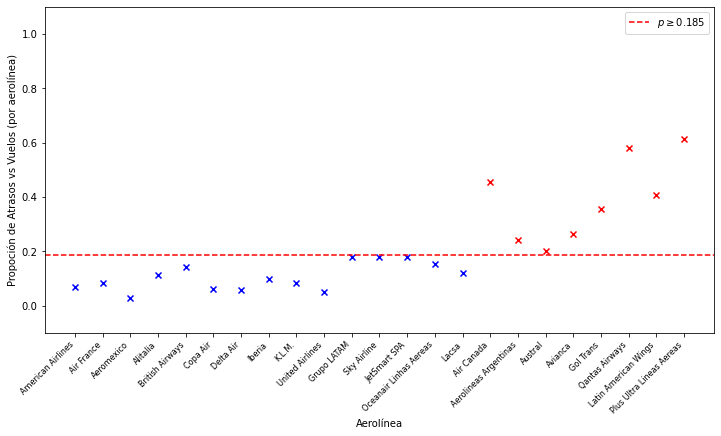

In [18]:
plt.figure(1,figsize=(12,6))
(n, bins, p) = plt.hist([df2['OPERA'][df2['atraso_15']==0],df2['OPERA'][df2['atraso_15']==1]],
                        23,edgecolor='black',stacked=True)
plt.xlabel('Aerolínea')
num, X = plt.xticks(rotation=45, ha="right",fontsize=8)
plt.legend(['A tiempo','Atraso'])
plt.show()

x = []
for s in X:
    x.append(s.get_text())
x = np.array(x)
prop = (n[1]-n[0])/n[1] 

plt.figure(2,figsize=(12,6))
plt.scatter(x[prop<=av_at],prop[prop<=av_at],marker='x',color='blue')
plt.scatter(x[prop>av_at],prop[prop>av_at],marker='x',color='red')
plt.axhline(y = av_at, color='red', linestyle='--',label=f'$p\geq {np.round(av_at,3)}$')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.ylim((0-0.1,1+0.1))
plt.legend()
plt.xlabel('Aerolínea')
plt.ylabel('Propoción de Atrasos vs Vuelos (por aerolínea)')
plt.show()

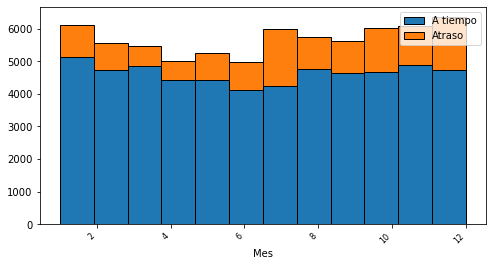

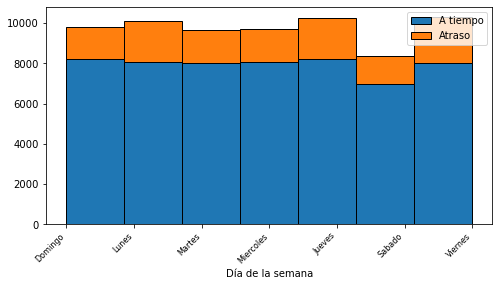

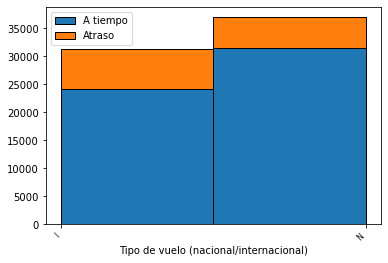

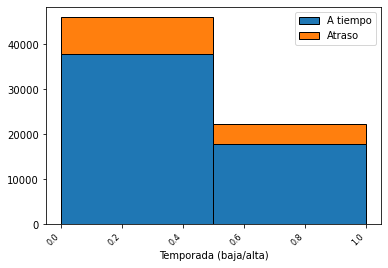

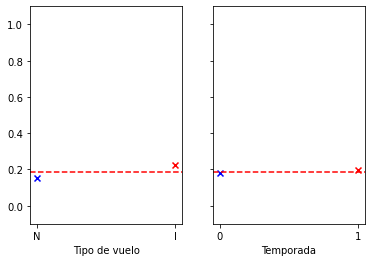

In [19]:
plt.figure(1,figsize=(8,4))
(n1, bins, p) = plt.hist([df2['MES'][df2['atraso_15']==0],df2['MES'][df2['atraso_15']==1]],
                        12,edgecolor='black',stacked=True)
plt.xlabel('Mes')
num1, X1 = plt.xticks(rotation=45, ha="right",fontsize=8)
plt.legend(['A tiempo','Atraso'])
plt.show()

####----------------------------------------------------

plt.figure(2,figsize=(8,4))
(n2, bins, p) = plt.hist([df2['DIANOM'][df2['atraso_15']==0],df2['DIANOM'][df2['atraso_15']==1]],
                        7,edgecolor='black',stacked=True)
plt.xlabel('Día de la semana')
num2, X2 = plt.xticks(rotation=45, ha="right",fontsize=8)
plt.legend(['A tiempo','Atraso'])
plt.show()

####----------------------------------------------------

plt.figure(3)
(n3, bins, p) = plt.hist([df2['TIPOVUELO'][df2['atraso_15']==0],df2['TIPOVUELO'][df2['atraso_15']==1]],
                        2,edgecolor='black',stacked=True)
plt.xlabel('Tipo de vuelo (nacional/internacional)')
num3, X3 = plt.xticks(rotation=45, ha="right",fontsize=8)
plt.legend(['A tiempo','Atraso'])
plt.show()

plt.figure(4)
(n4, bins, p) = plt.hist([df2['temporada_alta'][df2['atraso_15']==0],df2['temporada_alta'][df2['atraso_15']==1]],
                        2,edgecolor='black',stacked=True)
plt.xlabel('Temporada (baja/alta)')
num4, X4 = plt.xticks(rotation=45, ha="right",fontsize=8)
plt.legend(['A tiempo','Atraso'])
plt.show()

x3 = []
for s in X3:
    x3.append(s.get_text())
x3 = np.array(x3)
prop3 = (n3[1]-n3[0])/n3[1]

x4 = []
for s in X4:
    x4.append(s.get_text())
x4 = np.array(x4)
prop4 = (n4[1]-n4[0])/n4[1] 

x4 = np.array(['0','1'])

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(x3[prop3<=av_at],prop3[prop3<=av_at],marker='x',color='blue')
ax1.scatter(x3[prop3>av_at],prop3[prop3>av_at],marker='x',color='red')
ax1.axhline(y = av_at, color='red', linestyle='--',label=f'$p\geq {np.round(av_at,3)}$')
ax1.set_ylim([0-0.1, 1+0.1])
ax1.set_xlabel('Tipo de vuelo')

ax2.scatter(x4[prop4<=av_at],prop4[prop4<=av_at],marker='x',color='blue')
ax2.scatter(x4[prop4>av_at],prop4[prop4>av_at],marker='x',color='red')
ax2.axhline(y = av_at, color='red', linestyle='--',label=f'$p\geq {np.round(av_at,3)}$')
ax2.set_xlabel('Temporada')

plt.show()

In [20]:
fields = list(df2.columns)

#List of features used for the model training
fields_fm = fields
fields_fm.remove('Ori-I')
fields_fm.remove('Ori-O')
fields_fm.remove('dif_min')
fields_fm.remove('atraso_15')

fields_fm.remove('Fecha-O')
fields_fm.remove('Fecha-I')

num_cols = ['DIA','MES','AÑO','temporada_alta']
cat_cols = ['Vlo-I', 'Des-I', 'Emp-I', 'Vlo-O',
            'Des-O', 'Emp-O', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLAORI', 'SIGLADES', 'periodo_dia']


print(fields_fm)
X = df2[fields_fm]
y1 = df2['atraso_15']
y2 = df2['dif_min']


['Vlo-I', 'Des-I', 'Emp-I', 'Vlo-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLAORI', 'SIGLADES', 'temporada_alta', 'periodo_dia']


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,FunctionTransformer,OrdinalEncoder

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.2, random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=0)

In [22]:
#ct1 = ColumnTransformer([('s1', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)],
#                        remainder='passthrough')

#ct2 = ColumnTransformer([('s2', StandardScaler(), num_cols)],
#                        remainder='passthrough')

#ct = ColumnTransformer([
#     ('s2', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
#     ('s1', StandardScaler(), num_cols)])

ct = ColumnTransformer([
     ('s2', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols),
     ('s1', StandardScaler(), num_cols)])

In [25]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn import svm

model1 = LogisticRegression(max_iter=1000)
p1 = Pipeline([
    ('ct', ct),
    ('mod', model1)
])

model2 = DecisionTreeClassifier()
p2 = Pipeline([
    ('ct', ct),
    ('mod', model2)
])

model3 = GradientBoostingClassifier()
p3 = Pipeline([
    ('ct', ct),
    ('mod', model3)
])

In [ ]:
p1.fit(X_train1, y_train1)
print("\n%0.3f score para el modelo de regresión lineal\n" % p1.score(X_test1, y_test1))

p2.fit(X_train1, y_train1)
print("\n%0.3f score para el modelo de Árbol de decisión\n" % p2.score(X_test1, y_test1))

p3.fit(X_train1, y_train1)
print("\n%0.3f score para el modelo de Gradient boosted trees\n" % p3.score(X_test1, y_test1))